# Starfysh tutorial on real dataset with image integration

**Azizi Lab**

Siyu He, Yinuo Jin

08-19-2024

This is a tutorial on an example real Spatial Transcriptomics (ST) [data](https://drive.google.com/drive/folders/1RIp0Z2eF1m8Ortx0sgB4z5g5ISsRFzJ4?usp=share_link) (`CID44971_TNBC`) from [Wu *et al.*, 2021](https://www.nature.com/articles/s41588-021-00911-1).

## Overview
Starfysh performs cell-type deconvolution followed by various downstream analyses to discover spatial interactions in tumor microenvironment. Specifically, Starfysh looks for *anchor spots* (presumably with the highest compositions of one given cell type) informed by user-provided gene signatures ([see example](https://drive.google.com/file/d/1AXWQy_mwzFEKNjAdrJjXuegB3onxJoOM/view?usp=share_link)) as priors to guide the deconvolution inference, which further enables downstream analyses such as sample integration, spatial hub characterization, cell-cell interactions, etc. This tutorial focuses on the deconvolution task. Overall, Starfysh provides the following options:

**Base feature**:

- Spot-level deconvolution with expected cell types and corresponding annotated *signature* gene sets (default)

**Optional**:

- Archetypal Analysis (AA):<br>
    *If gene signatures are provided but require refinement*:
    
    - Novel cell type / cell state discovery (complementary to known cell types from the *signatures*)
    - Refine known marker genes by appending archetype-specific differentially expressed genes, and update anchor spots accordingly
    

- Product-of-Experts (PoE) integration
    
    Multi-modal integrative predictions with *expression* & *histology image* by leverging additional side information (e.g. cell density) from H&E image.


In [1]:
import sys
%load_ext autoreload
%autoreload 2
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip3 install scanpy
    !pip install git+https://github.com/azizilab/starfysh.git
    !pip install scikit-image --upgrade
    from google.colab import drive
    drive.mount('/content/drive')
    import sys

    # Please specify the colab notebook directory
    sys.path.append('/content/drive/MyDrive/Starfysh')

In [2]:
import os
import numpy as np
import pandas as pd
import torch

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import rcParams

import seaborn as sns
sns.set_style('white')

font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'

rcParams['font.family'] = plot_font
rcParams.update({'font.size': 10})
rcParams.update({'figure.dpi': 300})
rcParams.update({'figure.figsize': (3,3)})
rcParams.update({'savefig.dpi': 500})

import warnings
warnings.filterwarnings('ignore')

## Load starfysh

In [4]:
from starfysh import (AA, utils, plot_utils, post_analysis)
from starfysh import starfysh as sf_model

### (1). load data and marker genes

File Input:
- Spatial transcriptomics
    - Count matrix: `adata`
    - (Optional): Paired histology & spot coordinates: `img`, `map_info`

- Annotated signatures (marker genes) for potential cell types: `gene_sig`

Starfysh is built upon scanpy and Anndata. The common ST/Visium data sample folder consists a expression count file (usually `filtered_featyur_bc_matrix.h5`), and a subdirectory with corresponding H&E image and spatial information, as provided by Visium platform.

For example, our example real ST data has the following structure:
```
├── ../data
    bc_signatures_version_1013.csv

    ├── P1A_ER:
        \__ filtered_feature_bc_mactrix.h5

        ├── spatial:
            \__ aligned_fiducials.jpg
                detected_tissue_image.jpg
                scalefactors_json.json
                tissue_hires_image.png
                tissue_lowres_image.png
                tissue_positions_list.csv
```

For data that doesn't follow the common visium data structure (e.g. missing `filtered_feature_bc_matrix.h5` or the given `.h5ad` count matrix file lacks spatial metadata), please construct the data as Anndata synthesizing information as the example simulated data shows:

[Note]: If you're running this tutorial locally, please download the sample [data](https://drive.google.com/drive/folders/1RIp0Z2eF1m8Ortx0sgB4z5g5ISsRFzJ4?usp=share_link) and [signature gene sets](https://drive.google.com/file/d/1AXWQy_mwzFEKNjAdrJjXuegB3onxJoOM/view?usp=share_link), and save it in the relative path `../data` (otherwise please modify the `data_path` defined in the cell below):

In [5]:
# Specify data paths
data_path = 'data/'
sample_id = 'CID44971'
sig_name = 'bc_signatures_version_1013.csv'

In [6]:
# Load expression counts and signature gene sets
adata, adata_normed = utils.load_adata(data_folder=data_path,
                                       sample_id=sample_id, 
                                       n_genes=2000)

gene_sig = pd.read_csv(os.path.join(data_path, sig_name))
gene_sig = utils.filter_gene_sig(gene_sig, adata.to_df())
gene_sig.head()

[2024-08-20 02:17:28] Preprocessing1: delete the mt and rp
[2024-08-20 02:17:29] Preprocessing2: Normalize
[2024-08-20 02:17:29] Preprocessing3: Logarithm
[2024-08-20 02:17:29] Preprocessing4: Find the variable genes


Basal     LumA   LumB      MBC    CSC Normal epithelial    Tcm      Tem  \
0   EMP1  SH3BGRL   UGCG  COL11A2   CD44             KRT14   CCR7     IL7R   
1  TAGLN    HSPB1  ARMT1     SDC1    ESA             KRT17    LTB    ANXA1   
2  TTYH1    PHGR1  ISOC1     FBN2  CD133               LTF   IL7R    CXCR4   
3   RTN4     SOX9  GDF15     MMP1  ALDH1             KRT15  SARAF    KLRB1   
4    TK1    CEBPD  ZFP36    FABP5   CD24               PTN   SELL  TNFAIP3   

        Tfh     Treg  ... Plasmablasts   MDSC Monocytes   cDC     pDC  \
0    CXCL13  TNFRSF4  ...     IGKV3-15  ITGAM       LYZ  CD80   IL3RA   
1       NMB      LTB  ...        IGHG1   CD33      IL1B  CD86  LILRA4   
2     NR3C1     IL32  ...      IGKV1-5   ARG1      G0S2  CCR7   CD123   
3     DUSP4     BATF  ...     IGKV3-20   NOS2    TYROBP  CD1A    TCF4   
4  TNFRSF18    FOXP3  ...     IGKV3-11   CD68      FCN1  CD1C    IRF7   

  CAFs MSC iCAF-like CAFs myCAF-like PVL differentiated PVL immature  \
0               APOD          COL1A1              ACTA2        CCL19   
1                DCN          COL1A2              TAGLN         RGS5   
2              PTGDS          COL3A1               MYL9       IGFBP7   
3                CFD             LUM               TPM2     NDUFA4L2   
4                LUM           SFRP2           NDUFA4L2         CCL2   

  Endothelial  
0       ACKR1  
1       FABP4  
2       PLVAP  
3       RAMP2  
4         VWF  

[5 rows x 30 columns]

In [7]:
adata

AnnData object with n_obs × n_vars = 1162 × 18821
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'features', 'highly_variable'

In [8]:
gene_sig

Basal     LumA   LumB      MBC    CSC Normal epithelial    Tcm  \
0       EMP1  SH3BGRL   UGCG  COL11A2   CD44             KRT14   CCR7   
1      TAGLN    HSPB1  ARMT1     SDC1    ESA             KRT17    LTB   
2      TTYH1    PHGR1  ISOC1     FBN2  CD133               LTF   IL7R   
3       RTN4     SOX9  GDF15     MMP1  ALDH1             KRT15  SARAF   
4        TK1    CEBPD  ZFP36    FABP5   CD24               PTN   SELL   
..       ...      ...    ...      ...    ...               ...    ...   
84     FDCSP      NaN    NaN      NaN    NaN               NaN    NaN   
85  HLA.DPB1      NaN    NaN      NaN    NaN               NaN    NaN   
86    PCSK1N      NaN    NaN      NaN    NaN               NaN    NaN   
87   C4orf48      NaN    NaN      NaN    NaN               NaN    NaN   
88      CTSC      NaN    NaN      NaN    NaN               NaN    NaN   

        Tem       Tfh     Treg  ... Plasmablasts   MDSC Monocytes   cDC  \
0      IL7R    CXCL13  TNFRSF4  ...     IGKV3-15  ITGAM       LYZ  CD80   
1     ANXA1       NMB      LTB  ...        IGHG1   CD33      IL1B  CD86   
2     CXCR4     NR3C1     IL32  ...      IGKV1-5   ARG1      G0S2  CCR7   
3     KLRB1     DUSP4     BATF  ...     IGKV3-20   NOS2    TYROBP  CD1A   
4   TNFAIP3  TNFRSF18    FOXP3  ...     IGKV3-11   CD68      FCN1  CD1C   
..      ...       ...      ...  ...          ...    ...       ...   ...   
84      NaN       NaN      NaN  ...          NaN    NaN     NLRP3   NaN   
85      NaN       NaN      NaN  ...          NaN    NaN      CTSH   NaN   
86      NaN       NaN      NaN  ...          NaN    NaN      IER3   NaN   
87      NaN       NaN      NaN  ...          NaN    NaN       NaN   NaN   
88      NaN       NaN      NaN  ...          NaN    NaN       NaN   NaN   

       pDC CAFs MSC iCAF-like CAFs myCAF-like PVL differentiated PVL immature  \
0    IL3RA               APOD          COL1A1              ACTA2        CCL19   
1   LILRA4                DCN          COL1A2              TAGLN         RGS5   
2    CD123              PTGDS          COL3A1               MYL9       IGFBP7   
3     TCF4                CFD             LUM               TPM2     NDUFA4L2   
4     IRF7                LUM           SFRP2           NDUFA4L2         CCL2   
..     ...                ...             ...                ...          ...   
84     NaN                NaN             NaN                NaN          NaN   
85     NaN                NaN             NaN                NaN          NaN   
86     NaN                NaN             NaN                NaN          NaN   
87     NaN                NaN             NaN                NaN          NaN   
88     NaN                NaN             NaN                NaN          NaN   

   Endothelial  
0        ACKR1  
1        FABP4  
2        PLVAP  
3        RAMP2  
4          VWF  
..         ...  
84         NaN  
85         NaN  
86         NaN  
87         NaN  
88         NaN  

[89 rows x 30 columns]

**If there's no customized signature genesets, Starfysh defines "archetypal marker genes" as *signatures*. Please refer to the following code snippet and see details in section (3).**

```Python
aa_model = AA.ArchetypalAnalysis(adata_orig=adata_normed)
archetype, arche_dict, major_idx, evs = aa_model.compute_archetypes(r=40)
gene_sig = aa_model.find_markers(n_markers=30, display=False)
gene_sig = utils.filter_gene_sig(gene_sig, adata.to_df())
gene_sig.head()
```


In [9]:
# Load spatial information
img_metadata = utils.preprocess_img(data_path,
                                    sample_id,
                                    adata_index=adata.obs.index,
                                    rgb_channels=True)

img = img_metadata['img']
map_info = img_metadata['map_info']
if img.shape[2]==4:
    img = img[:,:,:3]
    img_metadata['img'] = img

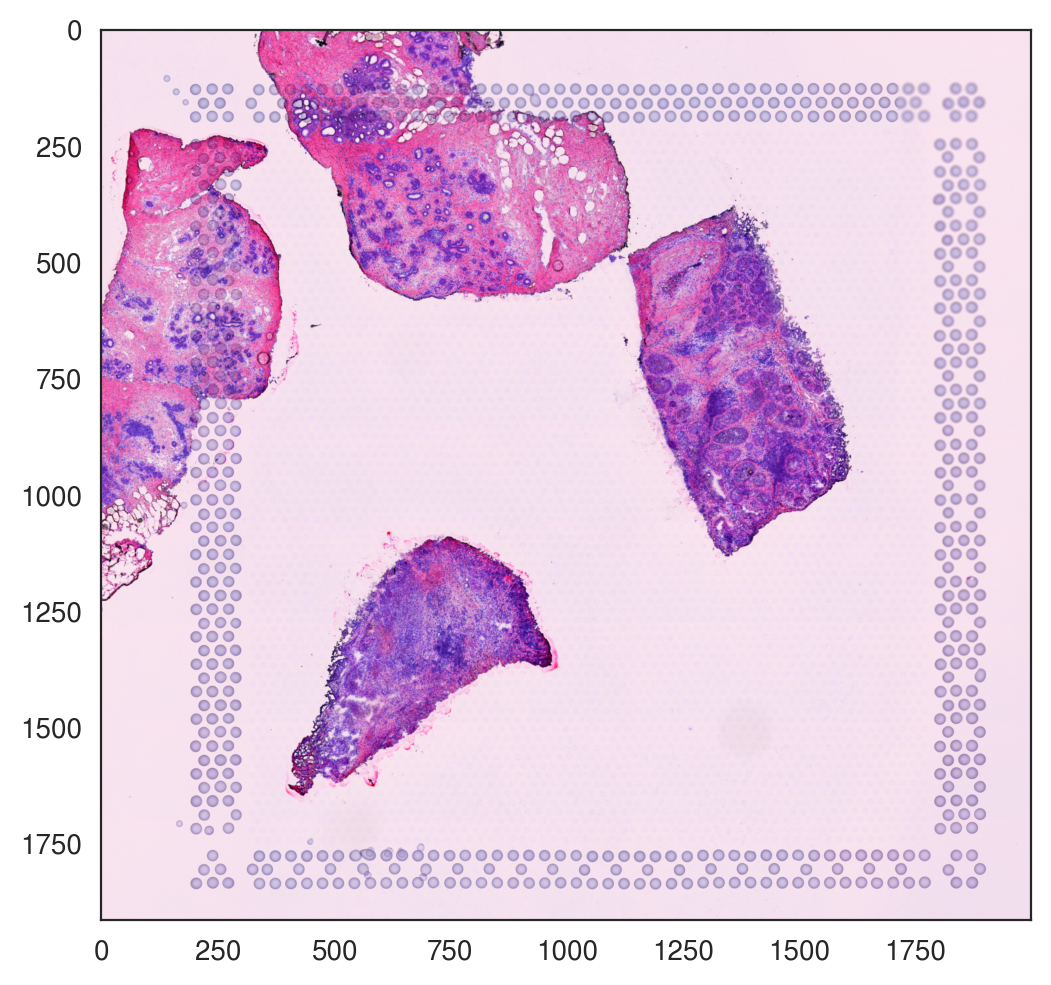

In [10]:
plt.figure(figsize=(6, 6), dpi=200)
plt.imshow(img)
plt.show()

### (2). Preprocessing (finding anchor spots)
- Identify anchor spot locations.

Instantiate parameters for Starfysh model training:
- Raw & normalized counts after taking highly variable genes
- filtered signature genes
- library size & spatial smoothed library size (log-transformed)
- Anchor spot indices (`anchors_df`) for each cell type & their signature means (`sig_means`)


In [11]:
# Parameters for training
visium_args = utils.VisiumArguments(adata,
                                    adata_normed,
                                    gene_sig,
                                    img_metadata,
                                    window_size=3, # adjust window_size for considering the neighbor density
                                    sample_id=sample_id)

# this code is necessar to update adata to include image info and loc info
adata, adata_normed = visium_args.get_adata()

[2024-08-20 02:17:35] Subsetting highly variable & signature genes ...
[2024-08-20 02:17:36] Smoothing library size by taking averaging with neighbor spots...
[2024-08-20 02:17:36] Retrieving & normalizing signature gene expressions...


       'HLA.DPB1'],
      dtype='object')
       'CH17-224D4.2', 'IGKV1-8', 'IGLV4-69', 'IGKV1-16', 'IGKV3D-11',
       'IGHV3-15'],
      dtype='object')
       'CD172A'],
      dtype='object')


[2024-08-20 02:17:39] Identifying anchor spots (highly expression of specific cell-type signatures)...


- Visualize spatial data

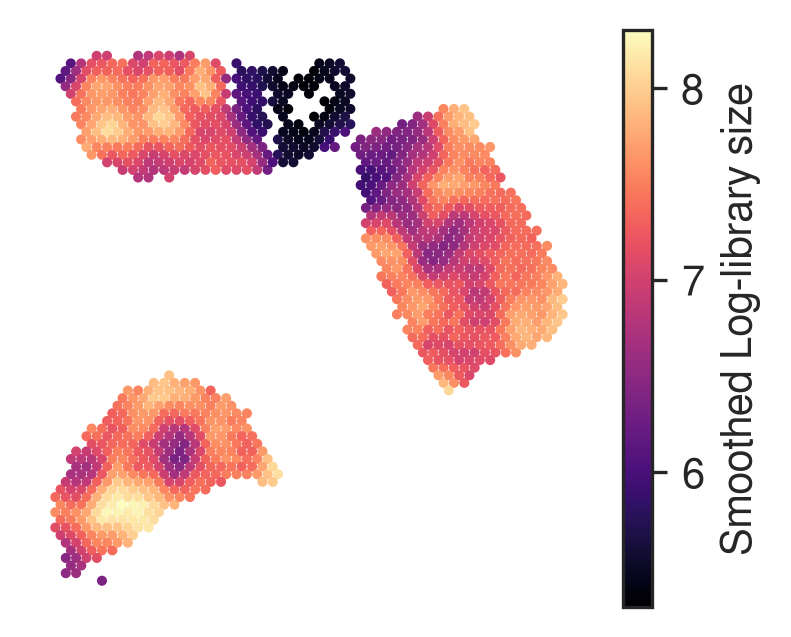

In [12]:
# Library size has been smoothed by the window size
plot_utils.plot_spatial_feature( data = adata,
                                 feature = visium_args.win_loglib,
                                 vmin=None,# adjust 
                                 vmax=None,# adjust 
                                 spot_size=2,# adjust 
                                 figsize = (3,2.5),
                                 fig_dpi = 300, # >300 for high quality img
                                 cmap = 'magma', 
                                 colorbar_on = True,
                                 label='Smoothed Log-library size' # label for the colorbar
                                )


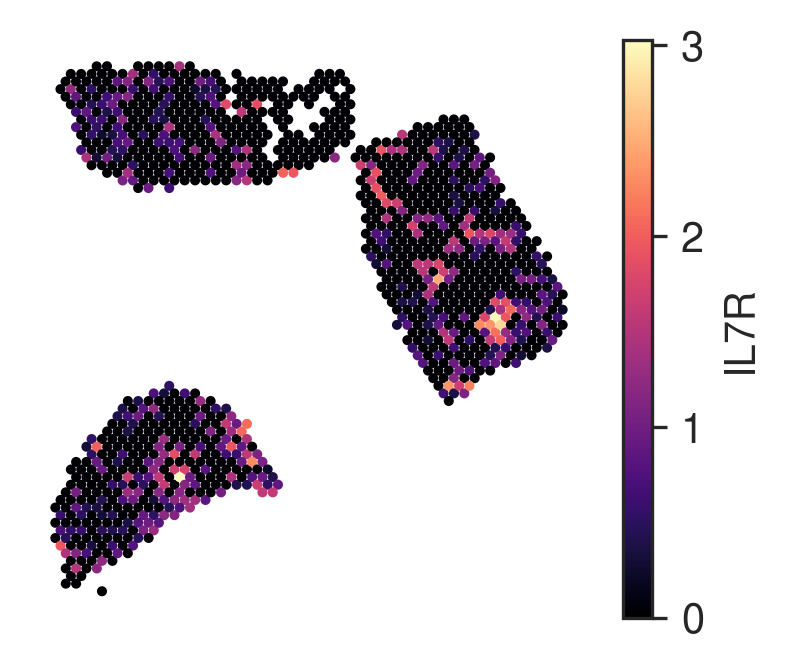

In [13]:
# plot for checking gene expression
plot_utils.plot_spatial_gene(adata,
                             adata_normed,
                             gene_name='IL7R',
                             log_gene = True,# True for normalied gene expresion, False for raw gene expression 
                             vmin=None,# adjust 
                             vmax=None,# adjust 
                             spot_size=2,# adjust 
                             figsize = (3,2.5),
                             fig_dpi = 300, # >300 for high quality img
                             cmap = 'magma', 
                             colorbar_on = True,
                            )

### (3). Optional: Archetypal Analysis
Overview:
The underlying assumption of archetypal analysis is that the geometric "extremes" are identified as the purest cell types, whereas all the other spots are mixture of the "archetypes". If the users provide the gene signature sets, they can still optionally apply AA to refine marker genes and update anchor spots for known cell types. In addition, AA can identify & assign potential novel cell types / states. Here are the features provided by the optional archetypal analysis:
- Finding archetypal spots & assign 1-1 mapping to their closest anchor spot neighbors
- Finding archetypal marker genes & append them to marker genes of annotated cell types
- Assigning novel cell type / cell states as the most distant archetypes


Note: <br>
- Intrinsic Dimension (ID) estimator is implemented to estimate the lower-bound for the number of archetypes $k$, followed by elbow method with iterations to identify the optimal $k$. By default, a [conditional number](https://scikit-dimension.readthedocs.io/en/latest/skdim.id.FisherS.html) is set as 30; if users find evidence of more / fewer cell types, please $\uparrow$ / $\downarrow$ `cn` accordingly.

#### - If complete signature genes are known

Users can skip this section & run Starfysh directly

#### - If signature genes are incomplete or require refinement

**In this tutorial, we'll show an example of applying best-aligned archetypes to existing `anchors` of given cell type(s) to append signature genes.**

In [14]:
aa_model = AA.ArchetypalAnalysis(adata_orig=adata_normed)
archetype, arche_dict, major_idx, evs = aa_model.compute_archetypes()

# (1). Find archetypal spots & archetypal clusters
arche_df = aa_model.find_archetypal_spots(major=True)

# (2). Find marker genes associated with each archetypal cluster
markers_df = aa_model.find_markers(display=False)

# (3). Map archetypes to the closest anchors within `r` nearest neighbors
# Choose the top `anchor_percent` (N%) anchors per cell type for archetype mapping
# In general, set lower `anchor_percent` for fine resolved cell-states
anchors_df = visium_args.get_anchors()
anchor_percent = 0.05
n_top_anchors = int(anchor_percent*adata.shape[0])
map_df, map_dict = aa_model.assign_archetypes(anchor_df=anchors_df[:n_top_anchors],
                                              r=n_top_anchors)

[2024-08-20 02:17:45] Computing intrinsic dimension to estimate k...


30 components are retained using conditional_number=30.00


[2024-08-20 02:17:48] Estimating lower bound of # archetype as 9...
[2024-08-20 02:18:14] 0.755 variance explained by raw archetypes.
Merging raw archetypes within 100 NNs to get major archetypes
[2024-08-20 02:18:14] Finding 100 nearest neighbors for each archetype...
[2024-08-20 02:18:14] Finding 30 top marker genes for each archetype...
... storing 'sample' as categorical


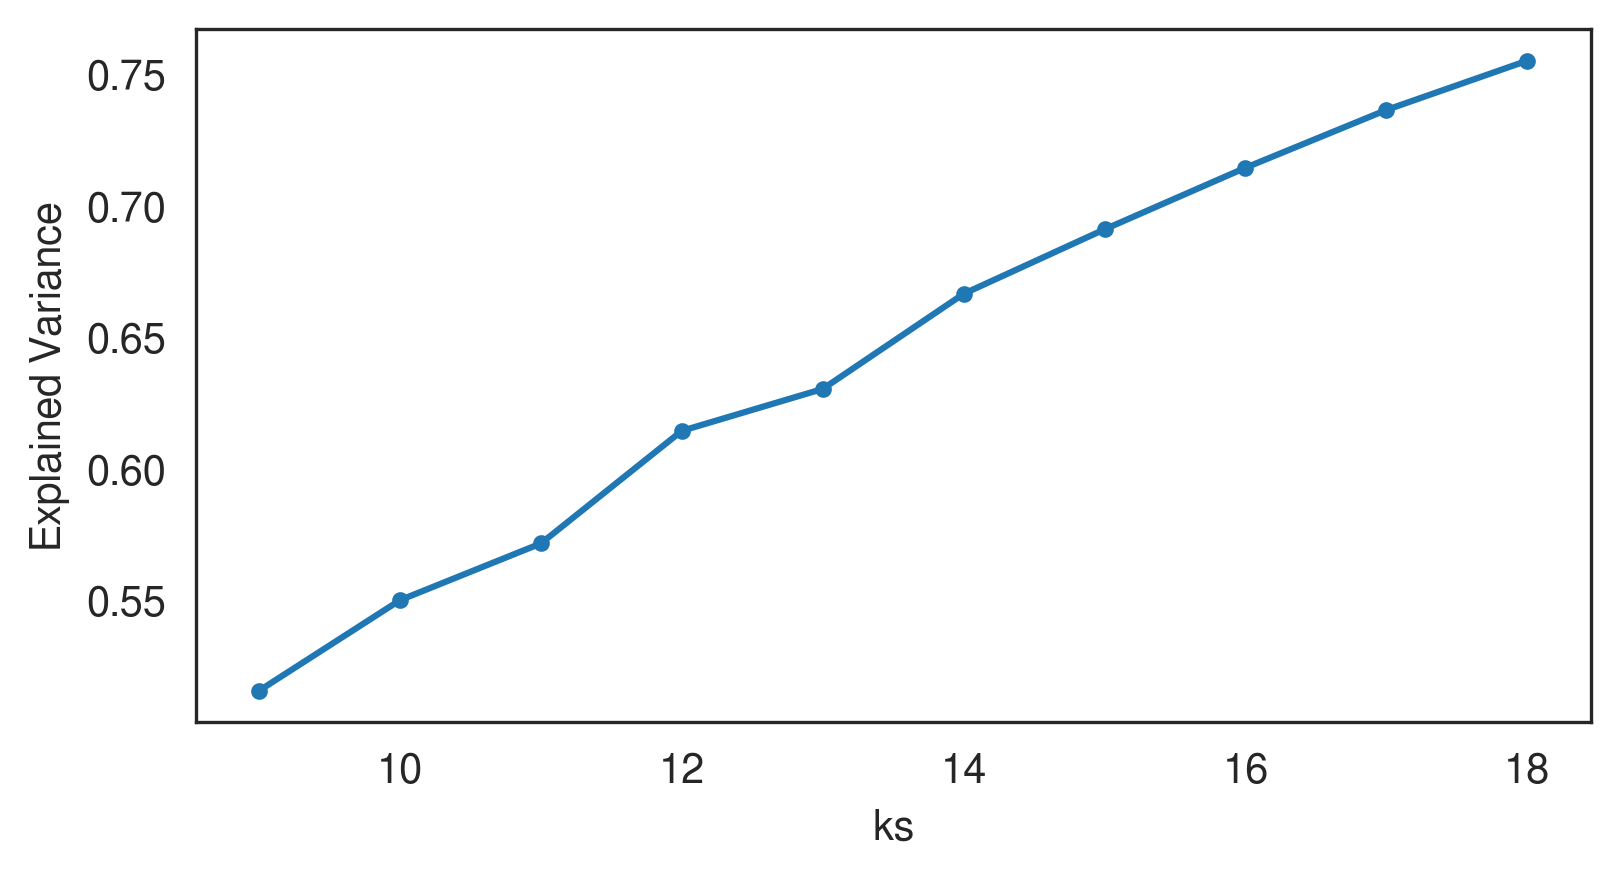

In [15]:
plot_utils.plot_evs(evs, kmin=aa_model.kmin)

- Visualize archetypes

[2024-08-20 02:18:22] Calculating UMAPs for counts + Archetypes...


(<Figure size 1800x1200 with 1 Axes>, <Axes: >)

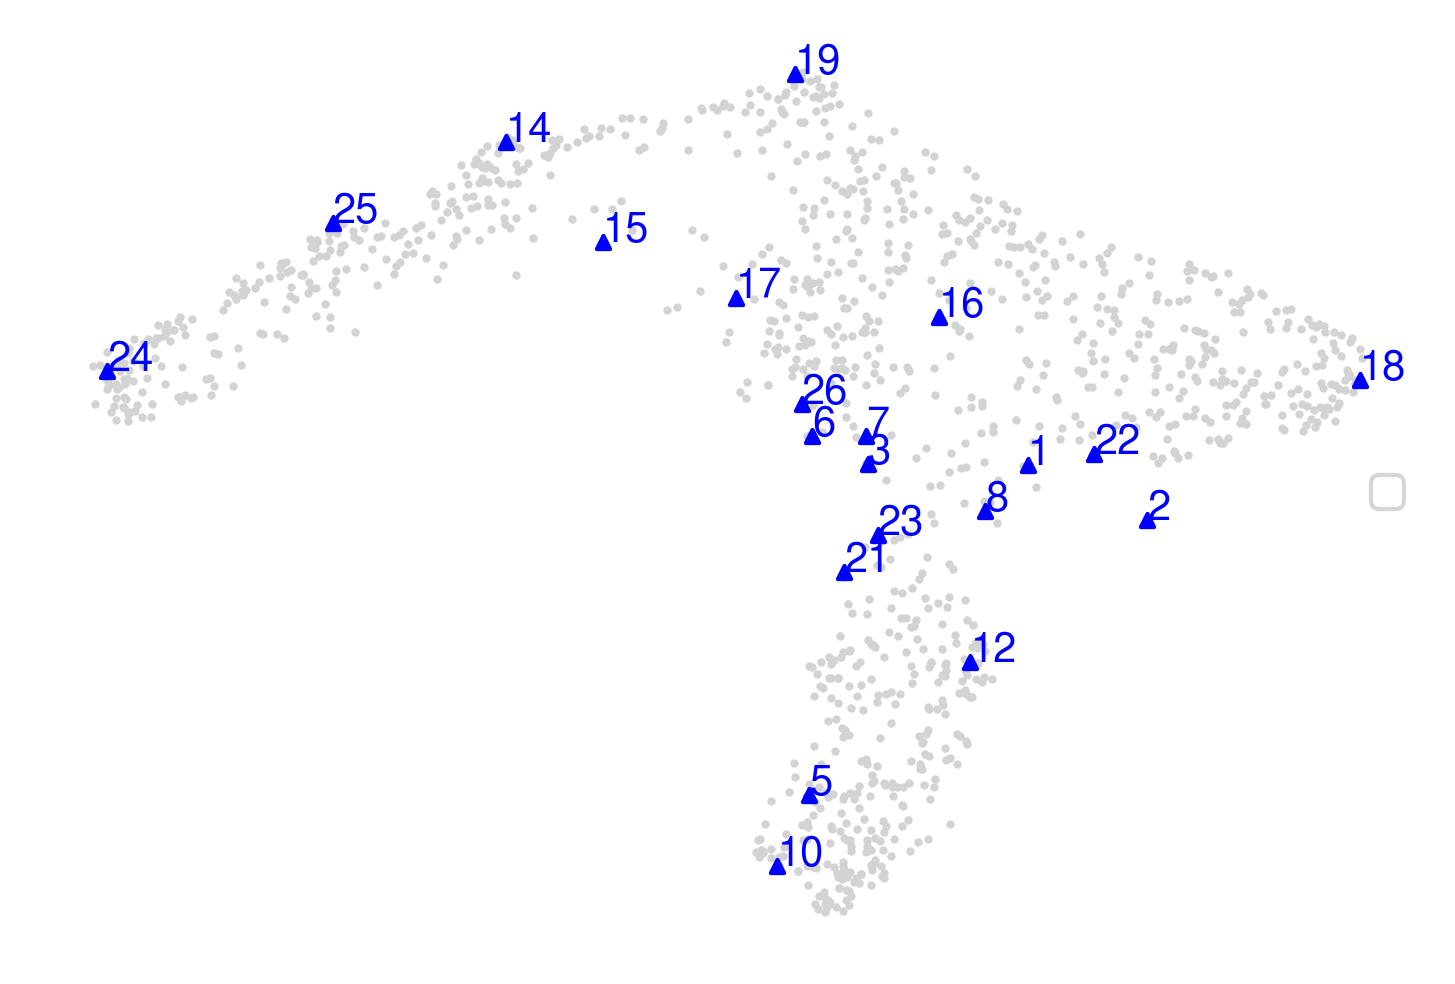

In [16]:
aa_model.plot_archetypes(do_3d=False, major=True, disp_cluster=False)

- Visualize "archetype" to "cell-type" mapping:

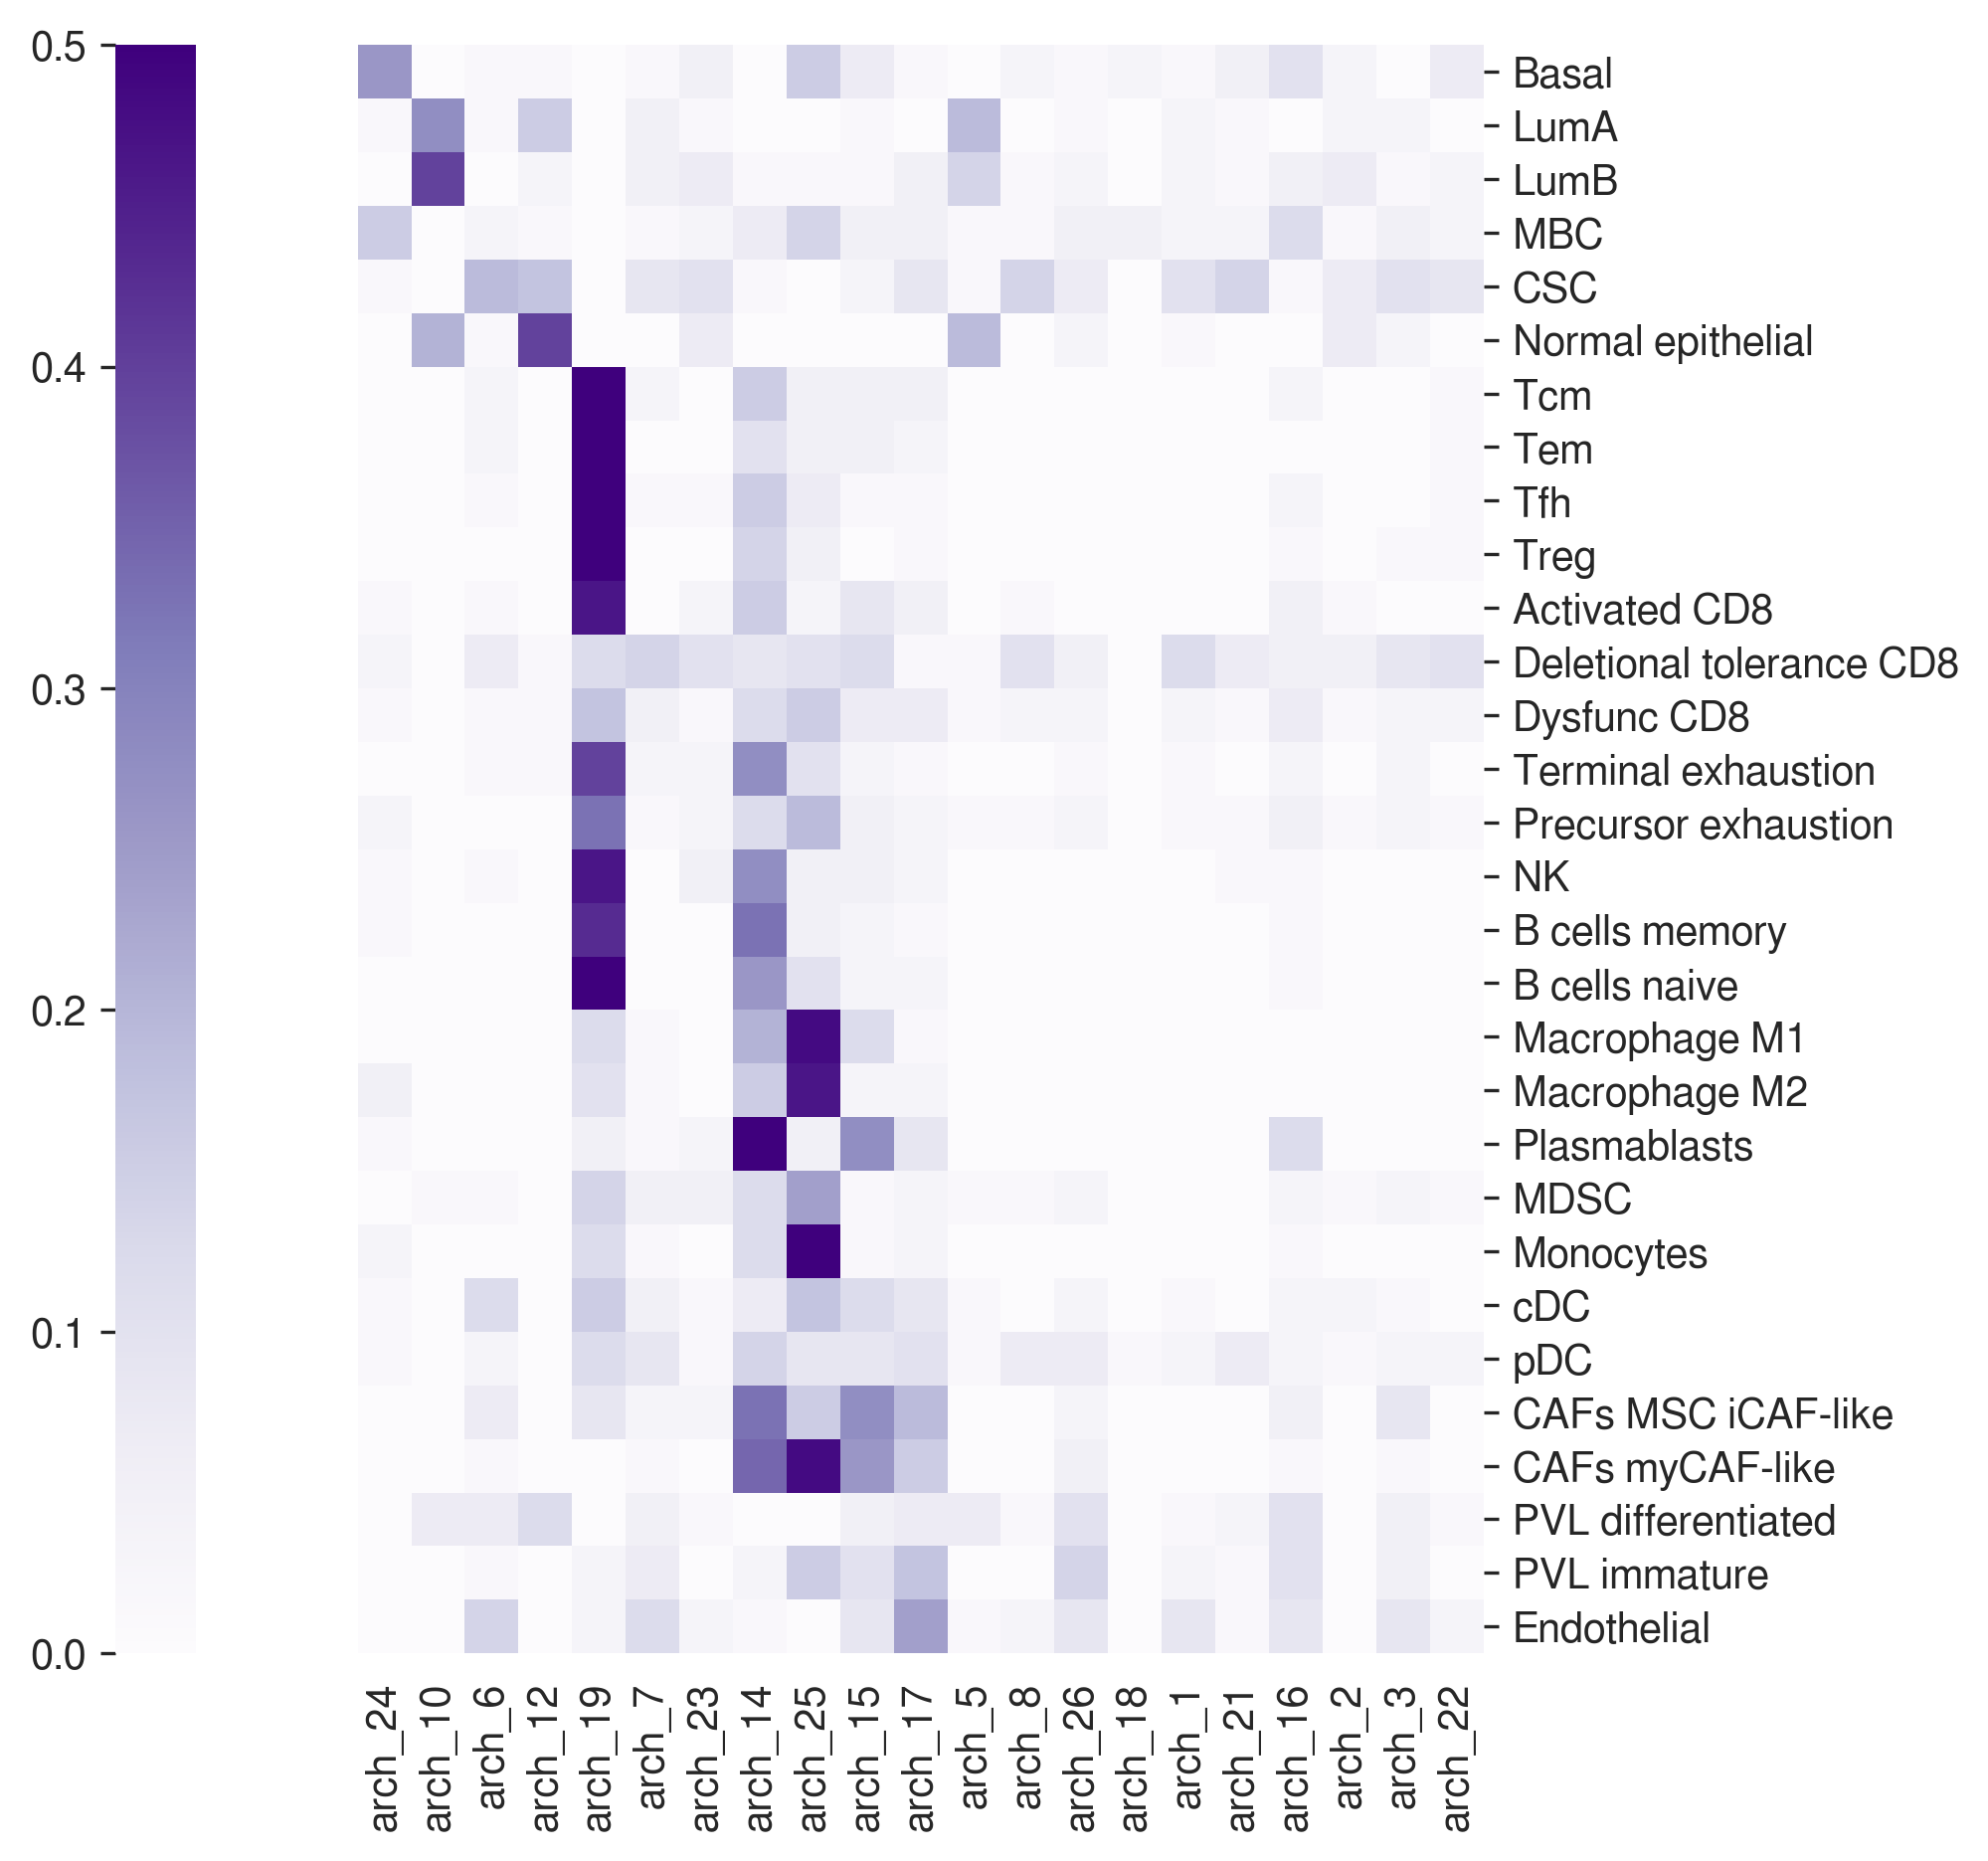

In [17]:
map_df_prop = map_df / n_top_anchors
fig, ax = plt.subplots(figsize=(7, 7), dpi=300)
g = sns.heatmap(map_df_prop[list(map_dict.values())], cmap='Purples', vmax=0.5, square=True, 
                cbar_kws=dict(location='left'), ax=ax)
ax.yaxis.tick_right()
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show()

-  Application: Append archetypal markers to signature genesets with the best-aligned cell types

In [18]:
map_dict

{'Basal': 'arch_24',
 'LumB': 'arch_10',
 'CSC': 'arch_6',
 'Normal epithelial': 'arch_12',
 'Tem': 'arch_19',
 'Deletional tolerance CD8': 'arch_7',
 'NK': 'arch_23',
 'Plasmablasts': 'arch_14',
 'Monocytes': 'arch_25',
 'CAFs MSC iCAF-like': 'arch_15',
 'Endothelial': 'arch_17',
 'LumA': 'arch_5',
 'pDC': 'arch_8',
 'PVL immature': 'arch_26',
 'Tfh': 'arch_18',
 'Terminal exhaustion': 'arch_1',
 'Precursor exhaustion': 'arch_21',
 'MBC': 'arch_16',
 'cDC': 'arch_2',
 'PVL differentiated': 'arch_3',
 'Dysfunc CD8': 'arch_22'}

In [19]:
visium_args = utils.refine_anchors(visium_args,
                                   aa_model,
                                   anchor_threshold=anchor_percent)

[2024-08-20 02:18:37] Finding 30 top marker genes for each archetype...
... storing 'sample' as categorical


       'HULC'],
      dtype='object')
       'IGLV4-69', 'IGKV1-16', 'IGLV1-47', 'IGLV2-23', 'IGKV3-15', 'IGHV3-15'],
      dtype='object')
       'CD16'],
      dtype='object')


[2024-08-20 02:18:42] Recalculating anchor spots (highly expression of specific cell-type signatures)...


## Run starfysh with histology integration (PoE)


We perform `n_repeat` random restarts and select the best model with lowest loss:


### (1). Model parameters

In [20]:
n_repeats = 1 # recommend >3 for selecting a better trained model 
epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### (2). Model training

Options:
- Without histology integration: `utils.run_starfysh(..., poe=False)` *(Default)*
- With histology integration: `utils.run_starfysh(..., poe=True)`

In [21]:
model, loss = utils.run_starfysh(visium_args,
                                 n_repeats=n_repeats,
                                 epochs=epochs,
                                 poe=True,
                                 device=device)

[2024-08-20 02:19:41] Running Starfysh with 1 restarts, choose the model with best parameters...
[2024-08-20 02:19:42] Initializing model parameters...
[2024-08-20 02:19:53] Epoch[10/200], train_loss: 16237.7980, train_reconst: 15908.2534, train_u: 18.0598,train_z: 64.8545,train_c: 219.4055,train_l: 27.2246
[2024-08-20 02:20:04] Epoch[20/200], train_loss: 14995.3793, train_reconst: 14730.3046, train_u: 18.0297,train_z: 56.8787,train_c: 186.2817,train_l: 3.8848
[2024-08-20 02:20:15] Epoch[30/200], train_loss: 14625.8384, train_reconst: 14382.3827, train_u: 18.0069,train_z: 53.1971,train_c: 171.1286,train_l: 1.1231
[2024-08-20 02:20:25] Epoch[40/200], train_loss: 14530.2513, train_reconst: 14294.9211, train_u: 17.9898,train_z: 50.5561,train_c: 165.5141,train_l: 1.2703
[2024-08-20 02:20:36] Epoch[50/200], train_loss: 14422.3299, train_reconst: 14193.8434, train_u: 17.9761,train_z: 48.6662,train_c: 160.4717,train_l: 1.3724
[2024-08-20 02:20:47] Epoch[60/200], train_loss: 14382.3321, train_

###  Downstream analysis

### (1). Parse Starfysh inference output

In [22]:
## information of inference_outputs and generative_outputs have been updated in adata_starfysh already
inference_outputs, generative_outputs, adata_starfysh = sf_model.model_eval(model,
                                                            adata,
                                                            visium_args,
                                                            poe=True,
                                                            device=device)

In [23]:
adata_starfysh

AnnData object with n_obs × n_vars = 1162 × 2611
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'features', 'highly_variable'
    uns: 'cell_types', 'spatial', 'qu'
    obsm: 'spatial', 'px', 'qc_m', 'qc', 'qz_m', 'qz_m_ct', 'qz_logv', 'qz_logv_ct', 'qz', 'ql_m', 'ql_logv', 'ql', 'qz_m_img', 'qz_logv_img', 'qz_img', 'qz_m_poe', 'qz_logv_poe', 'qz_poe', 'px_rate', 'px_scale', 'pc_p', 'xs_k', 'py_m', 'py_logv', 'px_rate_poe', 'py_m_poe', 'py_logv_poe', 'z_umap'
    varm: 'px_r', 'px_r_poe'

### (2).Visualize starfysh deconvolution results


**Inferred density on Spatial map:**

plot_utils.plot_spatial_density

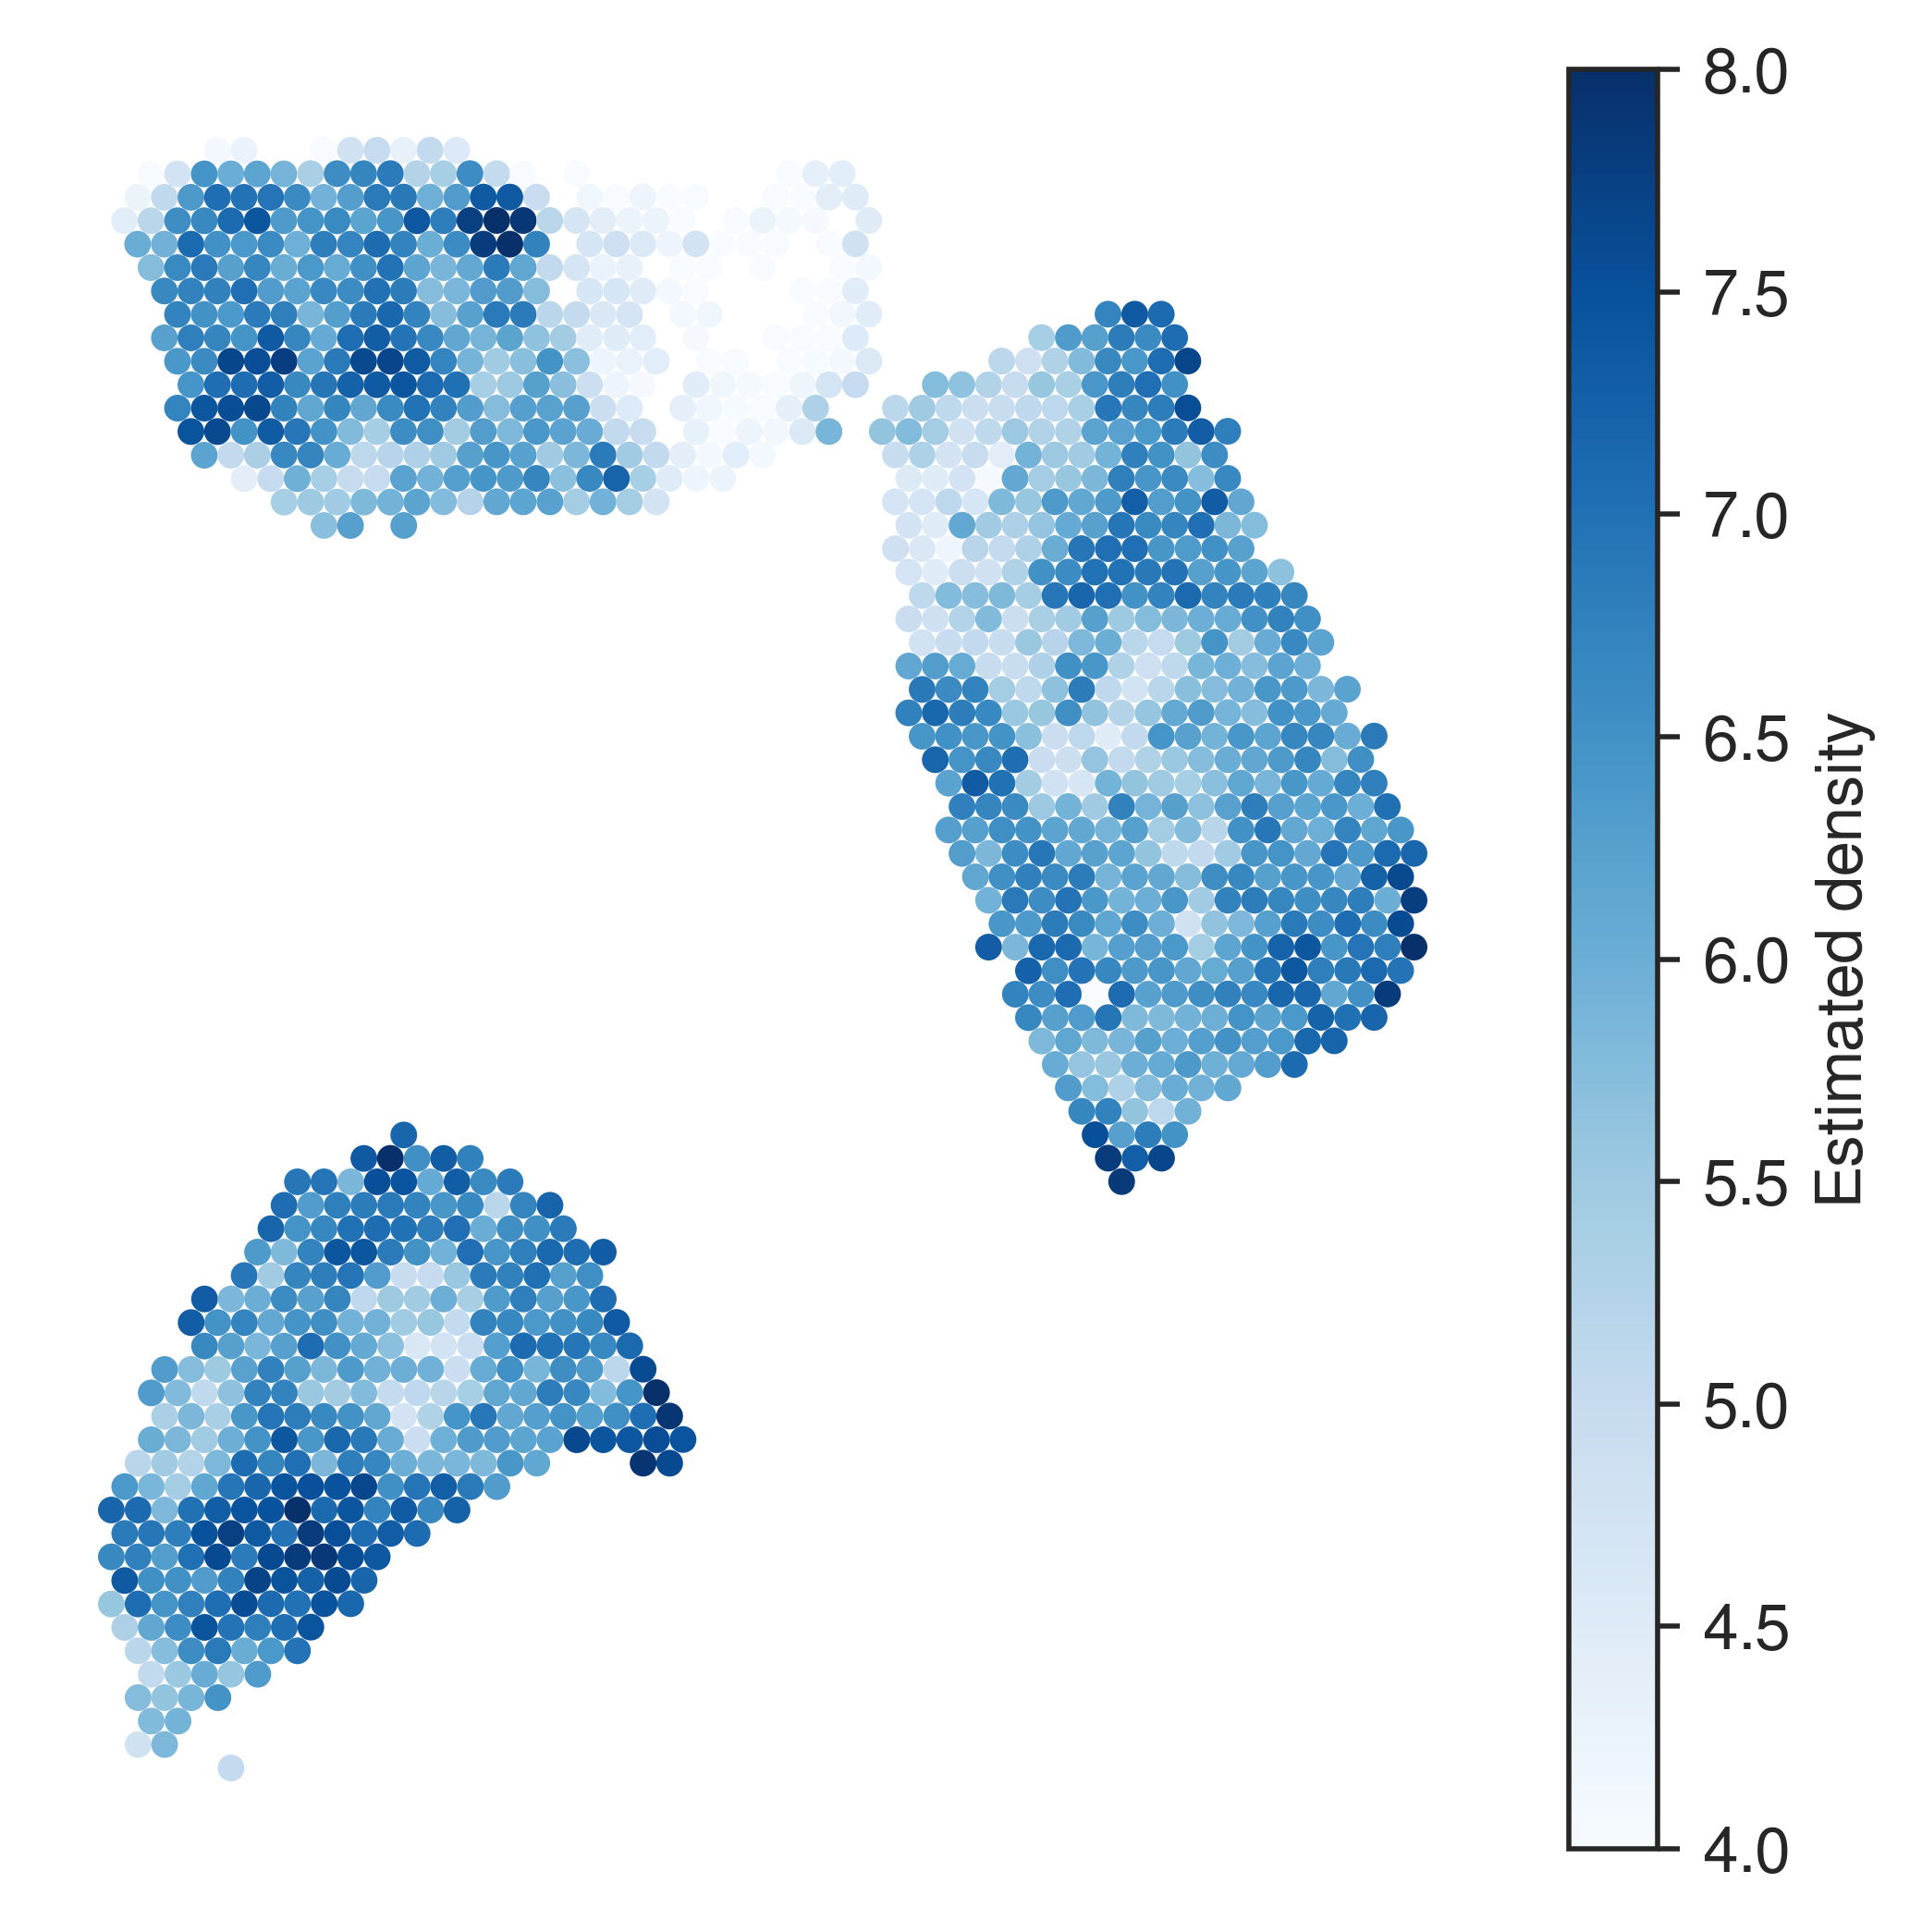

In [24]:
plot_utils.plot_spatial_density(data = adata_starfysh, 
                                vmin = 4, 
                                vmax = 8,
                                spot_size = 10,
                                figsize = (5,5),
                                fig_dpi = 500,
                                cmap = 'Blues',
                                colorbar_on = True
                               )


**Inferred cell-type proportions (spatial map):**

In [25]:
## to select the cell type, choose one in the list
adata_starfysh.uns['cell_types']

['Basal',
 'LumA',
 'LumB',
 'MBC',
 'CSC',
 'Normal epithelial',
 'Tcm',
 'Tem',
 'Tfh',
 'Treg',
 'Activated CD8',
 'Deletional tolerance CD8',
 'Dysfunc CD8',
 'Terminal exhaustion',
 'Precursor exhaustion',
 'NK',
 'B cells memory',
 'B cells naive',
 'Macrophage M1',
 'Macrophage M2',
 'Plasmablasts',
 'MDSC',
 'Monocytes',
 'cDC',
 'pDC',
 'CAFs MSC iCAF-like',
 'CAFs myCAF-like',
 'PVL differentiated',
 'PVL immature',
 'Endothelial']

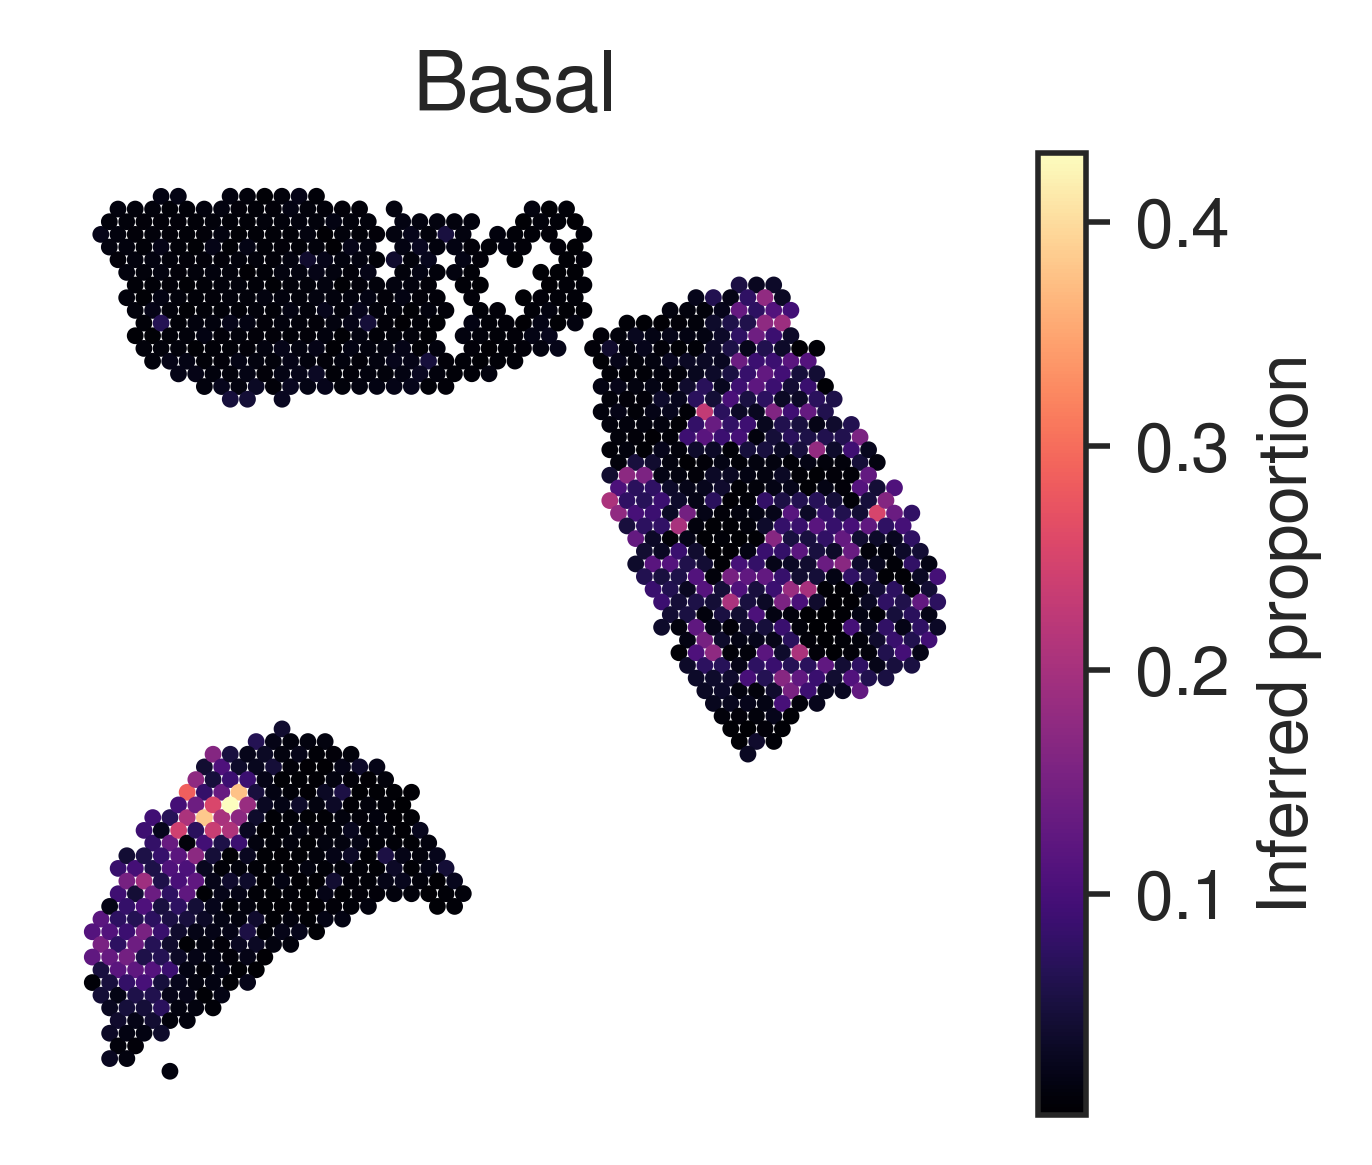

In [26]:
plot_utils.plot_spatial_cell_type_frac(  data = adata_starfysh,
                                         cell_type = 'Basal',
                                         vmin=None,# adjust 
                                         vmax=None,# adjust 
                                         spot_size=2,# adjust 
                                         figsize = (3,2.5),
                                         fig_dpi = 500, # >300 for high quality img
                                         cmap = 'magma', 
                                         colorbar_on = True,
                                         title = None,#'Basal' or other customized title for figure
                                         label='Inferred proportion'
                        )

**Inferred cell-type proportions on Z-space (UMAP):**

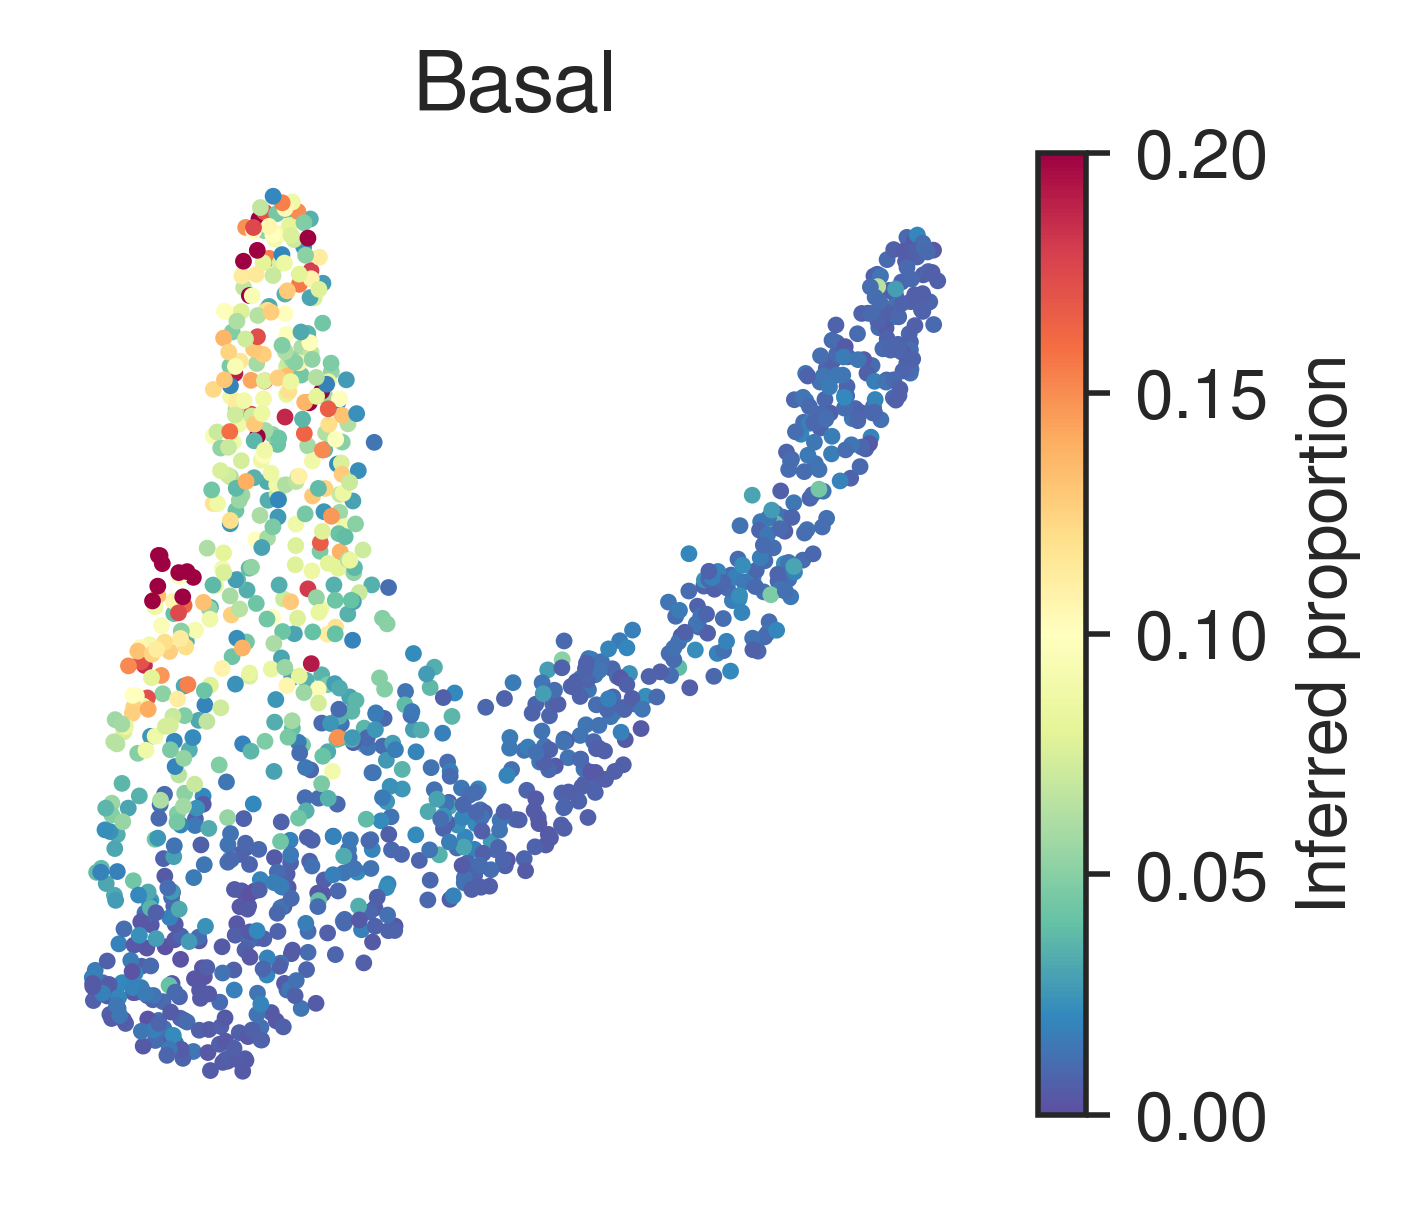

In [27]:
plot_utils.plot_z_umap_cell_type_frac(    data = adata_starfysh,
                                         cell_type = 'Basal',
                                         vmin=0,# adjust 
                                         vmax=0.2,# adjust 
                                         spot_size=2,# adjust 
                                         figsize = (3,2.5),
                                         fig_dpi = 500, # >300 for high quality img
                                         cmap = 'Spectral_r', 
                                         colorbar_on = True,
                                         title = None,#'Basal' or other customized title for figure
                                         label='Inferred proportion'
                        )

**Infer cell-type specific expressions from each spot**

In [29]:
pred_exprs = sf_model.model_ct_exp(model,
                                   adata_starfysh,
                                   visium_args,
                                   poe=True,
                                   device=device)

Plot spot-level expression (e.g. `IL7R` within *Effector Memory T cells (Tem)*):


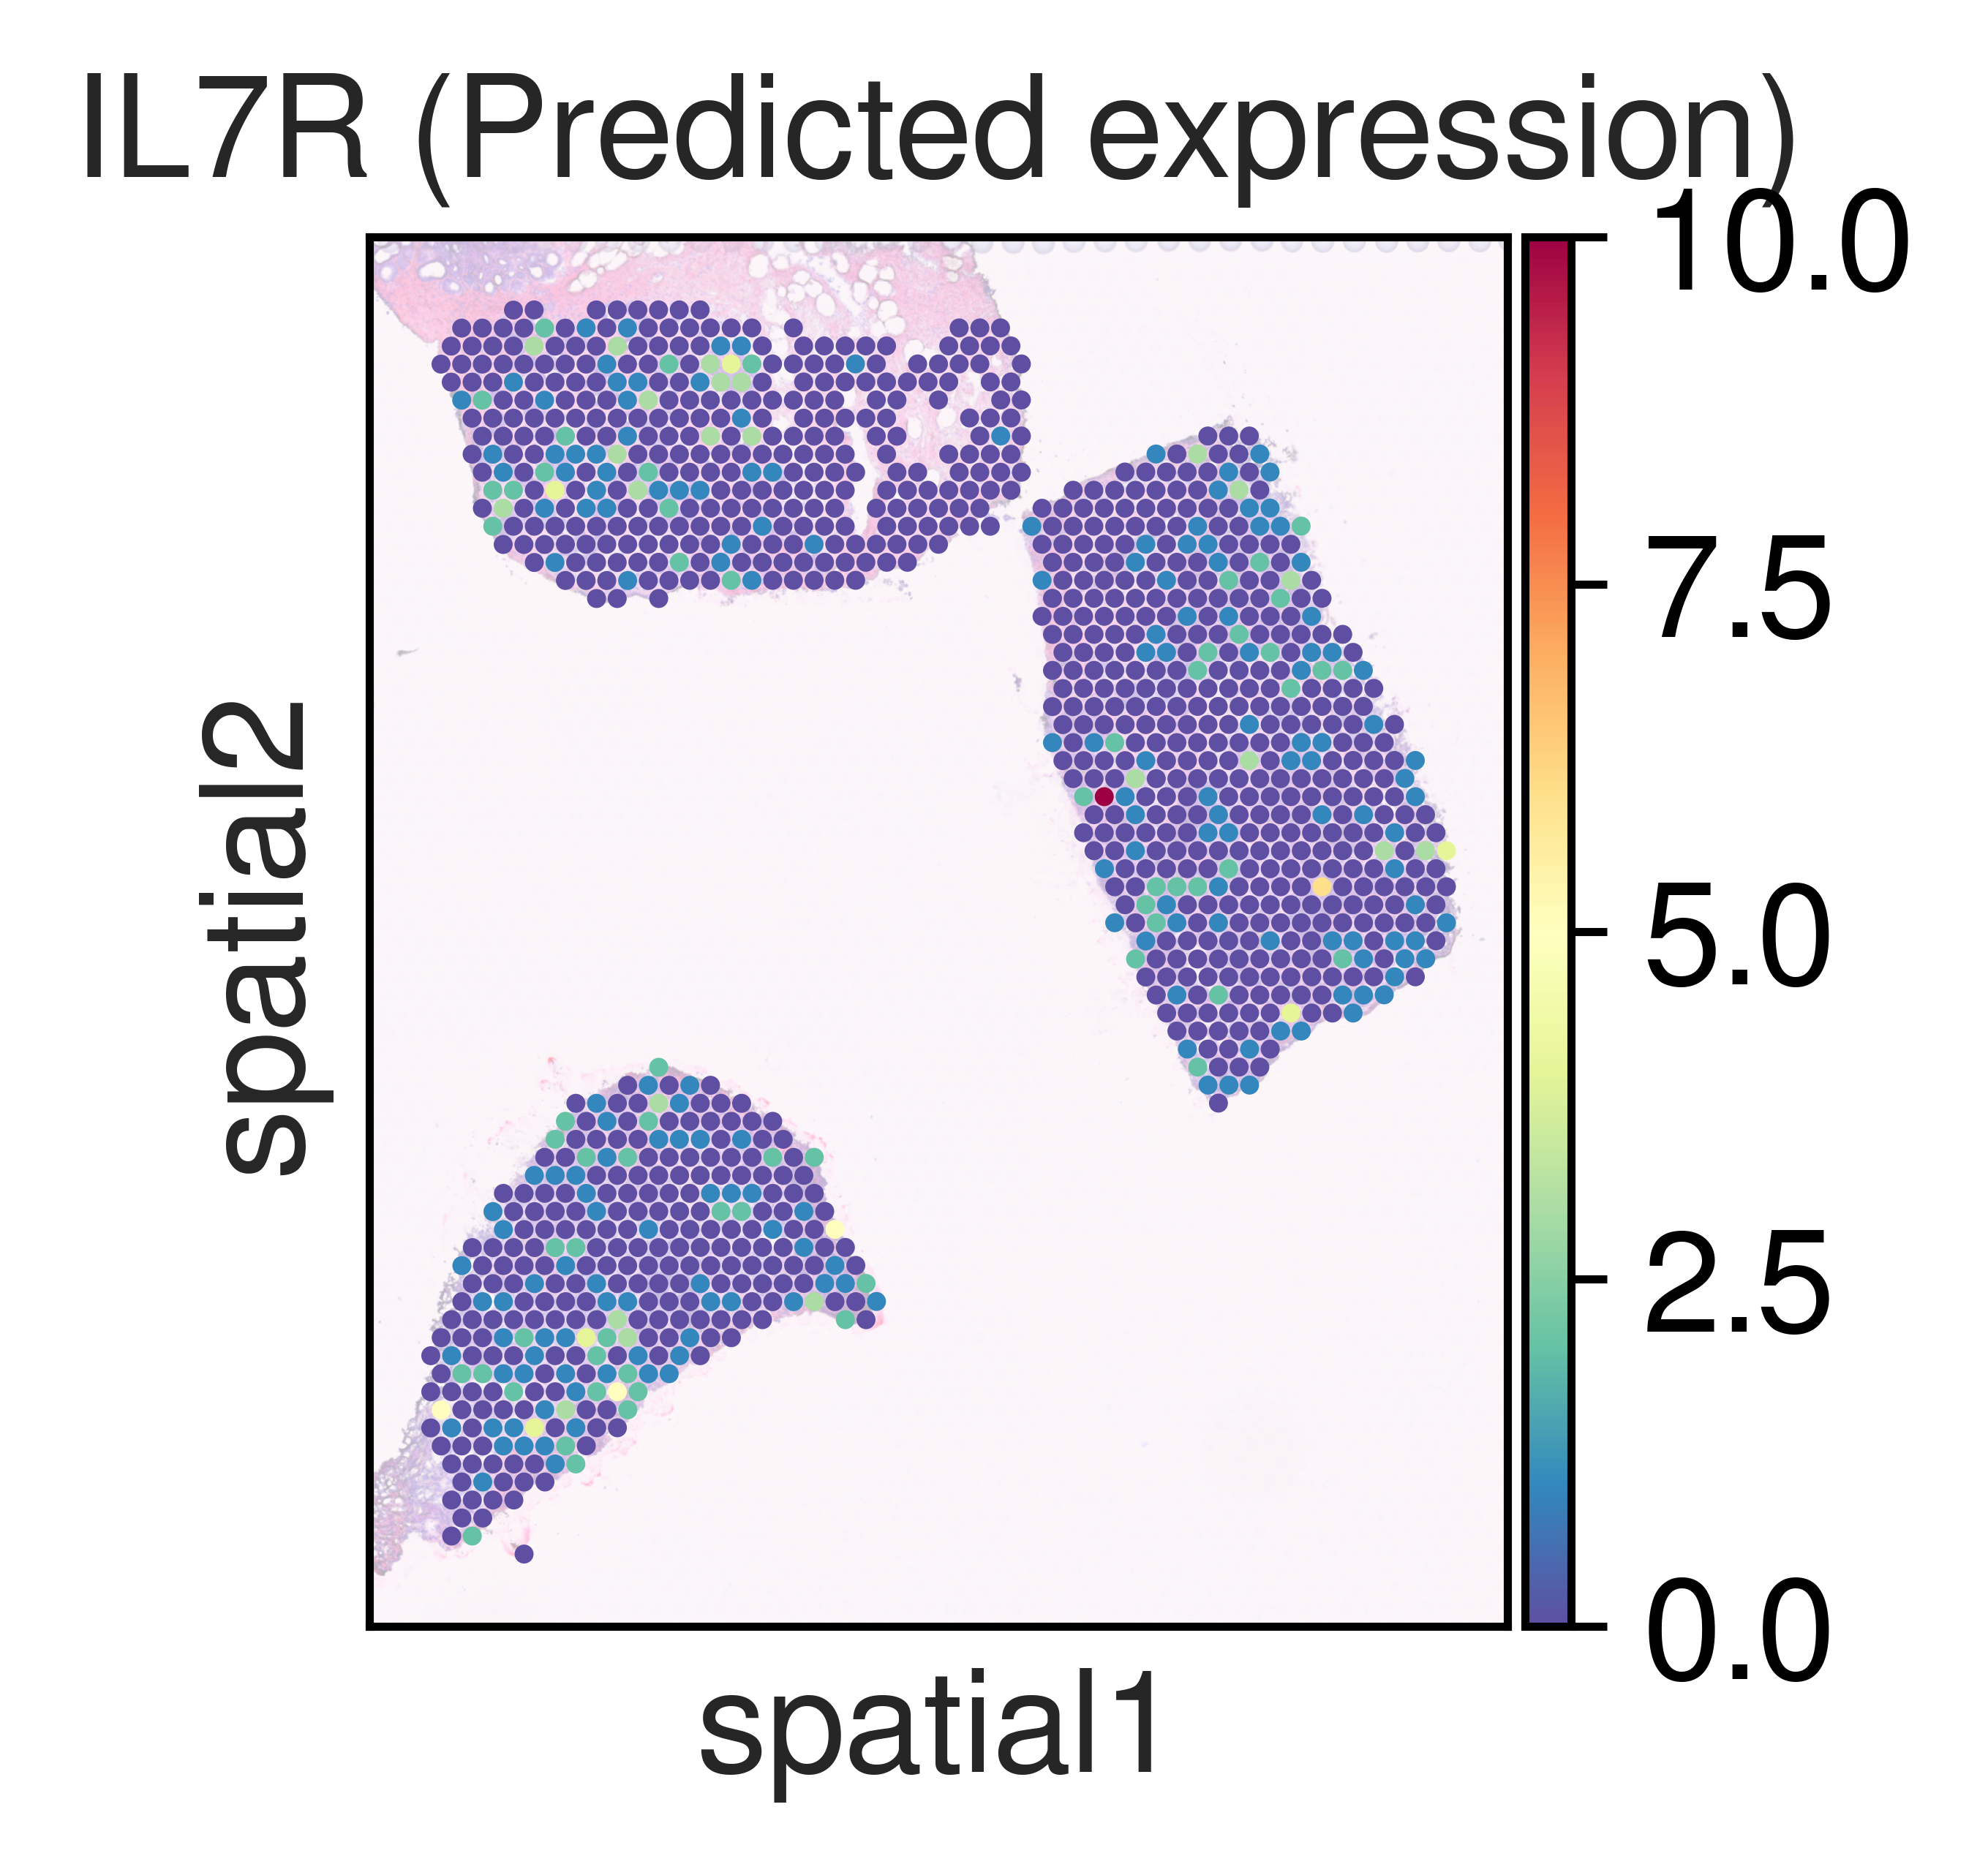

In [30]:
sample_gene = 'IL7R'
sample_cell_type = 'Tem'

plot_utils.pl_spatial_inf_gene(adata_starfysh,
                               factor=sample_cell_type,
                               feature=sample_gene,
                               vmin = 0,
                               vmax = 10,
                               spot_size = 100,
                               figsize = (3,2.5),
                               fig_dpi = 500,
                               alpha = 0.3, # add image as background. from 0 to 1
                               cmap = 'Spectral_r',                                        
                               colorbar_on = True,          
                               title = None ,           
                              )

### Save model & inferred parameters

In [25]:
# Specify output directory
outdir = './results/'
if not os.path.exists(outdir):
    os.mkdir(outdir)

# save the model
torch.save(model.state_dict(), os.path.join(outdir, 'starfysh_model.pt'))

# save `adata` object with inferred parameters
adata.write(os.path.join(outdir, 'st.h5ad'))

... storing 'sample' as categorical




---